# Solve NP Problems with finetuning

## Setup

In [ ]:
%pip install -q -r requirements.txt

In [ ]:
from NP_solver import *

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

hf_token = os.getenv("HF_TOKEN")

In [ ]:
!hf auth login --token $hf_token

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `LLM_course_UT` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab/LLM/LLM_NP_Problems/'
# path = '/content/drive/MyDrive/LLM_NP_Problems/'

Mounted at /content/drive/


### Dataset

In [ ]:
def create_dataset(args, len_dataset, random_state=42):
    data = []
    all_generated = []

    generator_args_list = list(ParameterSampler(
        param_distributions=args.generator_args,
        n_iter=len_dataset,
        random_state=random_state
    ))

    for i, generator_args in enumerate(generator_args_list):
        args.generator_args = generator_args
        generated = args.generator(**generator_args)
        problem_str = args.problem_formatter(*generated[:-1])
        system_message, human_message = args.prompt_creator(problem_str)

        assistant_message = ""
        for vertex in generated[-1]:
            assistant_message += f"{vertex:03d}"

        data.append({
            "conversations": [
                {"role": "system", "content": system_message },
                {"role": "user", "content": human_message },
                {"role": "assistant", "content": assistant_message}
            ],
            "idx": i
        })

        all_generated.append(generated)
    return Dataset.from_list(data), all_generated, generator_args_list

In [ ]:
def sort_dataset(dataset, generated):
    graph_orders = [(len(generated[idx][0]), i) for i, idx in enumerate(dataset['idx'])]
    sorted_graph_orders = sorted(graph_orders)
    indices = [order[1] for order in sorted_graph_orders]
    return Dataset.from_dict(dataset[indices])

## Hamiltonian Path Problem

In [ ]:
def create_ham_path_prompt_base(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Hamiltonian "
        "Path Problem. You receive an undirected graph where "
        "each line contains adjacent vertices for vertex. Your must "
        "return a path that visits every vertex exactly once. "
        "You must provide the sequence of vertices and no additional text.\n"
    )
    human_content = f"{formatted_problem_str}\nHamiltonian Path:\n"

    return system_content, human_content

In [ ]:
def format_graph_problem_for_llm_base(generated_graph):
    prompt = (f"Graph:\n")
    for vertex, neighbors in sorted(generated_graph.items()):
        prompt += f"{vertex:03d}:"
        for neighbor in sorted(neighbors):
            prompt += f"{neighbor:03d}"
        prompt += "\n"

    return prompt

In [ ]:
from NP_problems import verify_hamiltonian_path, generate_hamiltonian_path_graph, solve_hamiltonian_path_with_z3
args = TestProblemArgs(
    generator = generate_hamiltonian_path_graph,
    verifier = lambda ans,g,_: verify_hamiltonian_path(ans,g),
    answer_extractor = extract_subset_from_output,
    problem_formatter = format_graph_problem_for_llm_base,
    prompt_creator = create_ham_path_prompt_base,
    generator_args = {'num_vertices': randint(40,61), 'edge_density': uniform(0,1)}
)

In [ ]:
import pickle
def save_dataset(dataset, generated, generator_params, dataset_path, data_num):
    dataset.save_to_disk(os.path.join(dataset_path, f'dataset_{data_num}'))
    with open(os.path.join(dataset_path, f'generated_{data_num}.pickle'), 'wb') as f:
        pickle.dump(generated, f)
    with open(os.path.join(dataset_path, f'generator_params_{data_num}.pickle'), 'wb') as f:
        pickle.dump(generator_params, f)

from datasets import load_from_disk
def load_dataset(dataset_path, data_num):
    dataset = None
    generated = None
    generator_params = None
    if os.path.exists(os.path.join(dataset_path, f'dataset_{data_num}')):
        dataset = load_from_disk(os.path.join(dataset_path, f'dataset_{data_num}'))

    if os.path.exists(os.path.join(dataset_path, f'generated_{data_num}.pickle')):
        with open(os.path.join(dataset_path, f'generated_{data_num}.pickle'), 'rb') as f:
            generated = pickle.load(f)

    if os.path.exists(os.path.join(dataset_path, f'generator_params_{data_num}.pickle')):
        with open(os.path.join(dataset_path, f'generator_params_{data_num}.pickle'), 'rb') as f:
            generator_params = pickle.load(f)

    return dataset, generated, generator_params

In [ ]:
# dataset, generated, generator_params = create_dataset(args, 2000, random_state=42)
dataset_path = os.path.join(path, 'Dataset/')
# save_dataset(dataset, generated, generator_params, dataset_path, 4)
dataset, generated, generator_params = load_dataset(dataset_path, 2)

In [ ]:
split = dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = split['train']
test_dataset = split['test']

split = train_dataset.train_test_split(test_size=0.4, seed=42)
grpo_dataset = split['train']
sft_dataset = split['test']

len(sft_dataset),len(grpo_dataset),len(test_dataset)

(380, 570, 50)

In [ ]:
def get_sequence_length(tokenizer, number_of_vertices):
    args = TestProblemArgs(
        generator = generate_hamiltonian_path_graph,
        verifier = lambda ans,g,_: verify_hamiltonian_path(ans,g),
        answer_extractor = extract_subset_from_output,
        problem_formatter = format_graph_problem_for_llm_base,
        prompt_creator = create_ham_path_prompt_base,
        generator_args = {'num_vertices': [number_of_vertices], 'edge_density': [1]}
    )
    dataset, generated, generator_parameters = create_dataset(args, 1, random_state=42)
    sample = dataset[0]

    conv = sample["conversations"]
    prompt = [msg for msg in conv if msg["role"] != "assistant"]
    inputs = tokenizer.apply_chat_template(prompt, return_tensors="pt")
    max_prompt_length = len(inputs[0])

    inputs = tokenizer.apply_chat_template(conv, return_tensors="pt")
    max_seq_length = len(inputs[0])
    return max_prompt_length, max_seq_length-max_prompt_length

In [ ]:
max_prompt_length = 10290
max_completion_length = 105
max_seq_length = max_prompt_length+max_completion_length

## SFT

In [ ]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit",
    max_seq_length = max_seq_length,
    fast_inference = False,
    gpu_memory_utilization=1.0,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 32,
    lora_dropout = 0,
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 08-29 11:09:56 [__init__.py:241] Automatically detected platform cuda.
ERROR 08-29 11:09:57 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.8: Fast Llama patching. Transformers: 4.55.2. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.8.8 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
get_sequence_length(tokenizer, 100)

(10290, 105)

In [ ]:
from collections import defaultdict

def plot_trl_training_history(history):
    metrics = defaultdict(list)
    for step in history[:-1]:
        for metric_name, value in step.items():
            if metric_name in ['step','epoch']:
              continue
            metrics[metric_name].append(value)

    plt.figure()
    for metric_name, values in metrics.items():
        plt.plot(values, label=metric_name)
        plt.title(metric_name)
        plt.xlabel("Steps")
        plt.ylabel("Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def formatting_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

sft_dataset = sft_dataset.map(
    formatting_func,
    batched=True,
)

In [ ]:
from trl import SFTConfig, SFTTrainer

sft_path = "./sft_outputs/"
sft_args = SFTConfig(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 2,

    fp16 = True,
    warmup_steps = 8,
    num_train_epochs = 1,
    weight_decay = 0.02,
    max_length = max_seq_length,

    logging_steps = 1,
    save_steps = 16,

    learning_rate = 5e-4,
    lr_scheduler_type = "cosine",
    neftune_noise_alpha=5,
    max_grad_norm=0.3,

    seed = 3407,
    output_dir = "sft_outputs",
    report_to = "none",
)

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = sft_dataset,
    dataset_text_field = "text",
    args = sft_args,
)
trainer_stats = trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/760 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 760 | Num Epochs = 1 | Total steps = 190
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 48,627,712 of 3,261,377,536 (1.49% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.287000
2,2.215700
3,1.745200
4,1.316200
5,1.437400
6,1.556000
7,1.168400
8,0.604400
9,1.319900
10,0.965100


Step,Training Loss
1,1.287000
2,2.215700
3,1.745200
4,1.316200
5,1.437400
6,1.556000
7,1.168400
8,0.604400
9,1.319900
10,0.965100


In [ ]:
model.save_pretrained(os.path.join(path,'models/sft-4-llama-instruct'))

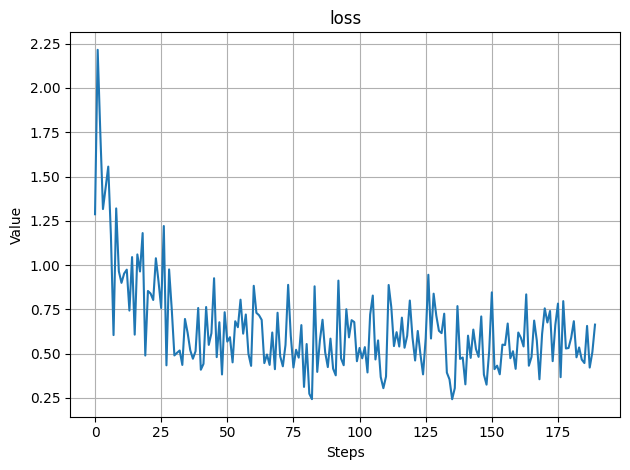

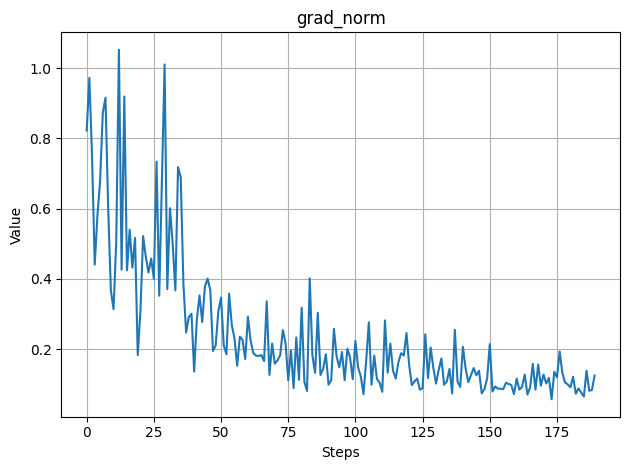

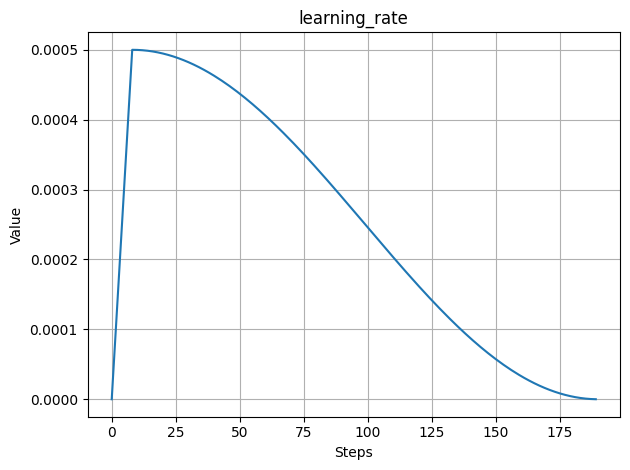

In [ ]:
plot_trl_training_history(trainer.state.log_history)

## GRPO

In [ ]:
def extract_subset_from_output(llm_output):
    pattern = re.compile(r"\d\d\d", re.IGNORECASE)
    subset = pattern.findall(llm_output.strip())
    return [int(number) for number in subset]

In [ ]:
def reward_func_for_hampath(completions, idx, **kwargs):
    reward_list = []

    for completion, i in zip(completions, idx):
        vertices = extract_subset_from_output(completion[0]['content'])
        if len(vertices) < 2:
            reward_list.append(0)
            continue

        g, _ = generated[i]
        visited = set([vertices[0]])

        reward = 0.0
        if vertices[0] in g:
            reward += 1

        last_vertex = min(len(g), len(vertices))
        for u, v in zip(vertices[:last_vertex-1], vertices[1:last_vertex]):
            if v in g and u in g[v] and v not in visited:
                reward += 1
                visited.add(v)
            # else: # Uncomment for Hard Reward
            #     break

        reward /= len(g)
        reward_list.append(reward)

    return reward_list

In [ ]:
from trl import GRPOConfig, GRPOTrainer

grpo_path = os.path.join(path,"./Checkpoints/grpo_4/")
grpo_args = GRPOConfig(
    warmup_steps = 16,
    max_grad_norm = 0.8,
    temperature=1.0,

    learning_rate = 4e-5,
    lr_scheduler_type = "polynomial",
    num_train_epochs = 1,
    loss_type="dr_grpo",
    neftune_noise_alpha=3,

    logging_steps = 1,
    save_total_limit=2,
    save_steps = 128,
    log_completions = False,

    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 1,

    num_generations = 4,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,

    report_to = "none",
    output_dir = grpo_path,
    mask_truncated_completions=False,
    scale_rewards=False,
    shuffle_dataset = False,
)

In [ ]:
grpo_formatter = lambda examples: {"prompt": [example[:-1] for example in examples["conversations"]]}

grpo_dataset = sort_dataset(grpo_dataset, generated)
grpo_dataset = grpo_dataset.map(
    grpo_formatter,
    batched=True,
)
grpo_dataset

Map:   0%|          | 0/1140 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations', 'idx', 'prompt'],
    num_rows: 1140
})

In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs=reward_func_for_hampath,
    args = grpo_args,
    train_dataset = grpo_dataset,
)
trainer.train(resume_from_checkpoint=True)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,140 | Num Epochs = 1 | Total steps = 1,140
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 48,627,712 of 3,261,377,536 (1.49% trained)
	save_steps: 128 (from args) != 16 (from trainer_state.json)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 131072, 'temperature': 0.6, 'top_p': 0.9}. If this is not desired, please set these values explicitly.


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / reward_func_for_hampath / mean,rewards / reward_func_for_hampath / std
897,0.001400,0.571429,0.043741,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.435945,0.571429,0.043741
898,0.001600,0.642857,0.048357,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.595643,0.642857,0.048357
899,0.001600,0.558036,0.039596,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.580518,0.558036,0.039596
900,0.001300,0.486607,0.218400,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.311177,0.486607,0.218400
901,0.001300,0.473214,0.224224,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.281411,0.473214,0.224224
902,0.001300,0.464286,0.227284,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.310593,0.464286,0.227284
903,0.001500,0.500000,0.183851,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.472167,0.500000,0.183851
904,0.001100,0.401786,0.215028,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.071196,0.401786,0.215028
905,0.001300,0.642857,0.071429,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.263871,0.642857,0.071429
906,0.001500,0.558036,0.022470,105.000000,105.000000,105.000000,1.000000,0.000000,0.000000,0.000000,1.475560,0.558036,0.022470


Unsloth: Will smartly offload gradients to save VRAM!


In [ ]:
model.save_pretrained(os.path.join(path,'models/sft-grpo-4-llama-instruct'))

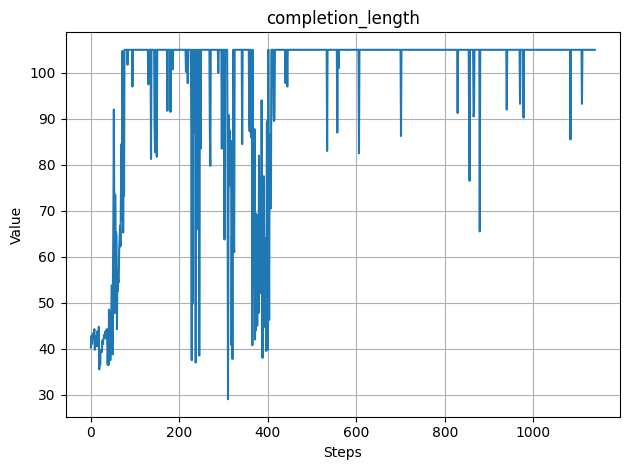

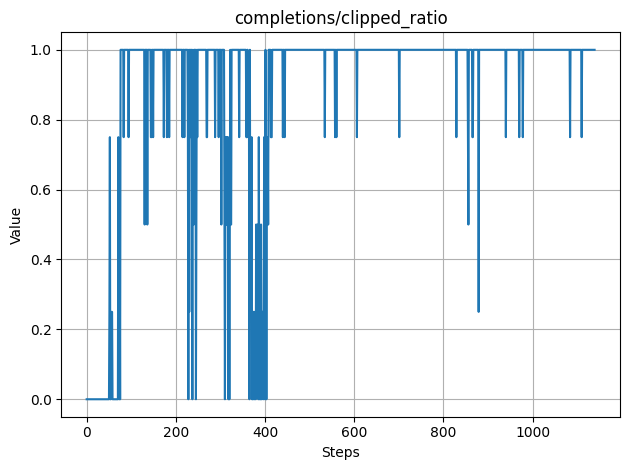

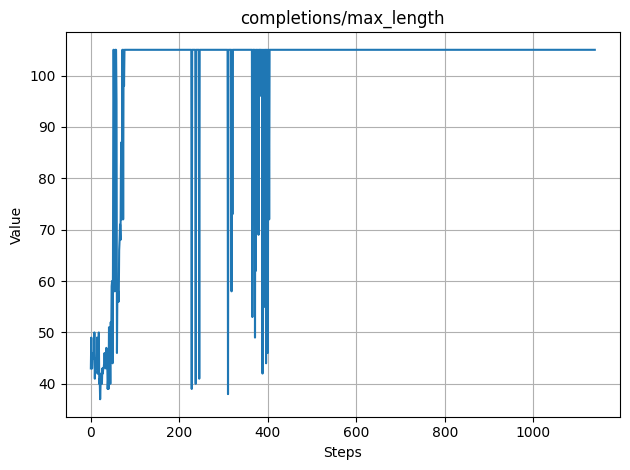

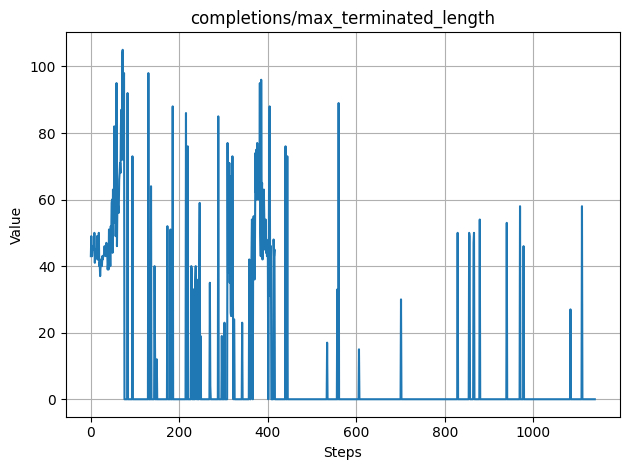

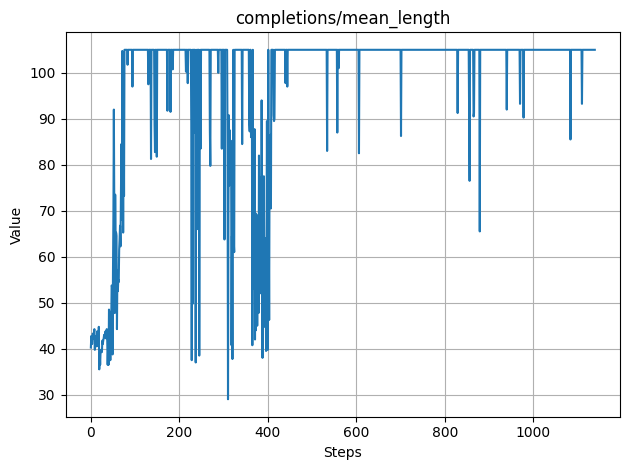

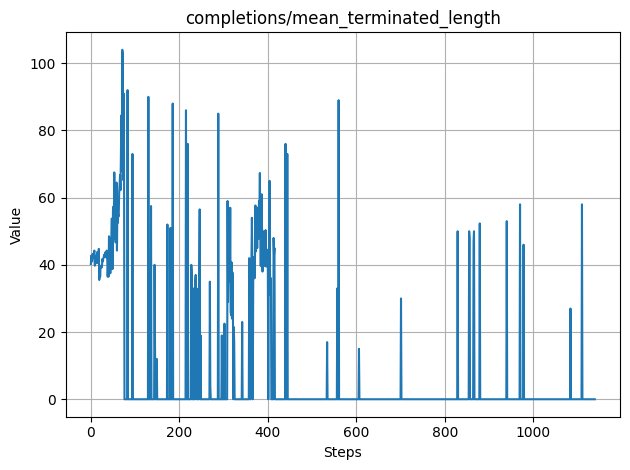

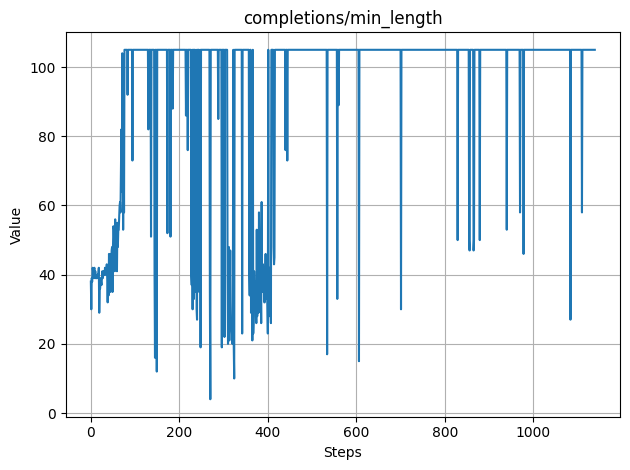

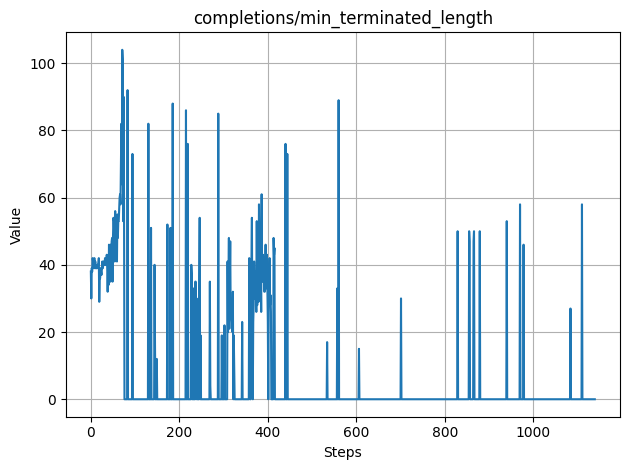

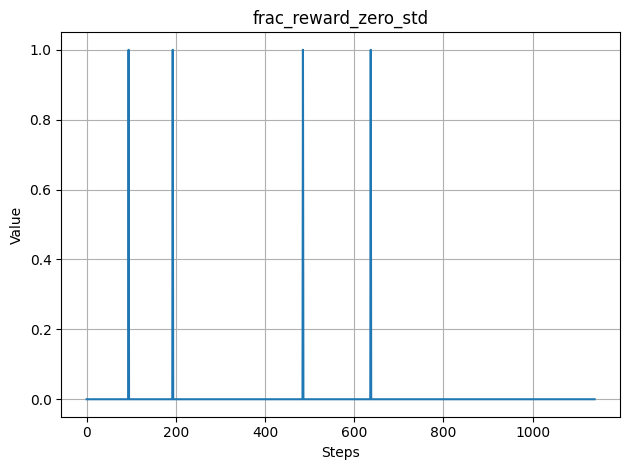

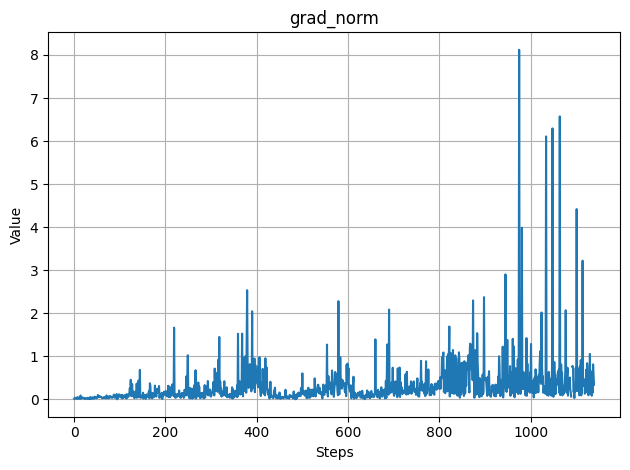

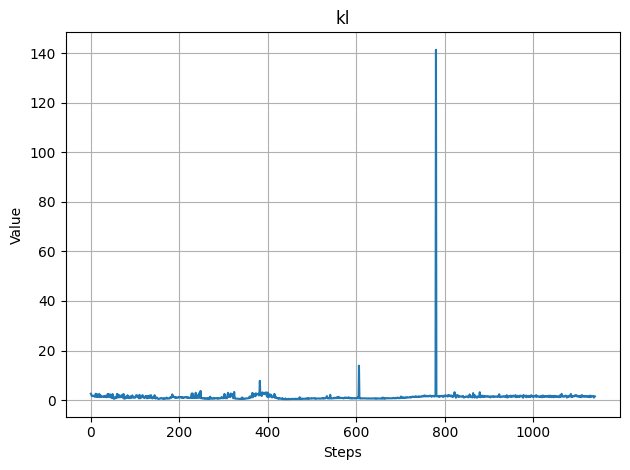

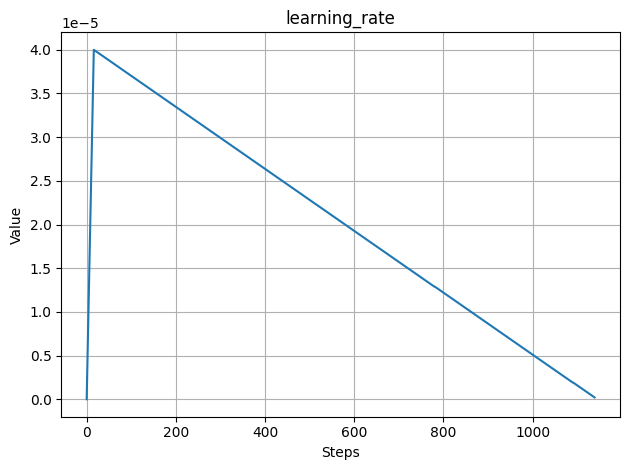

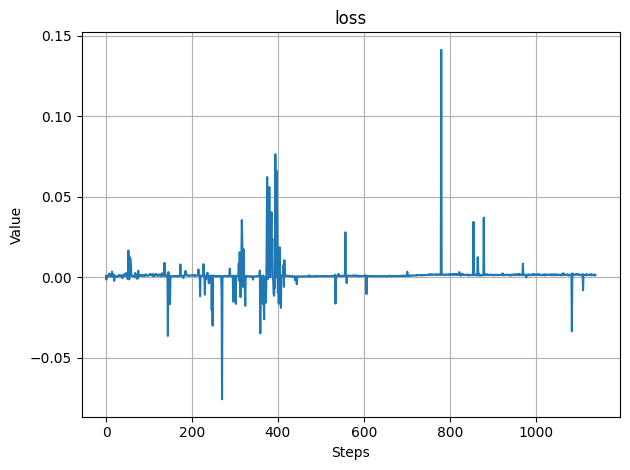

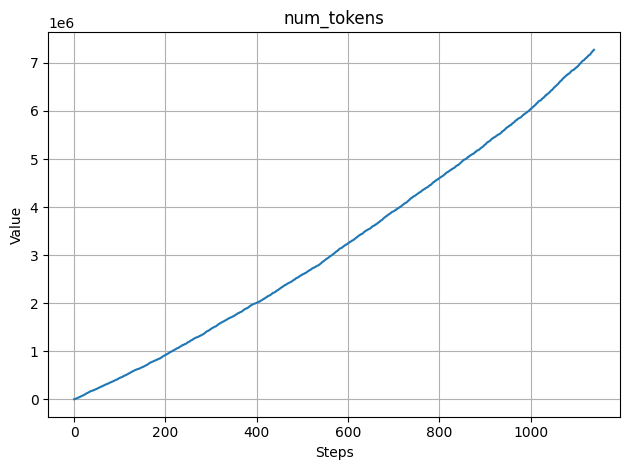

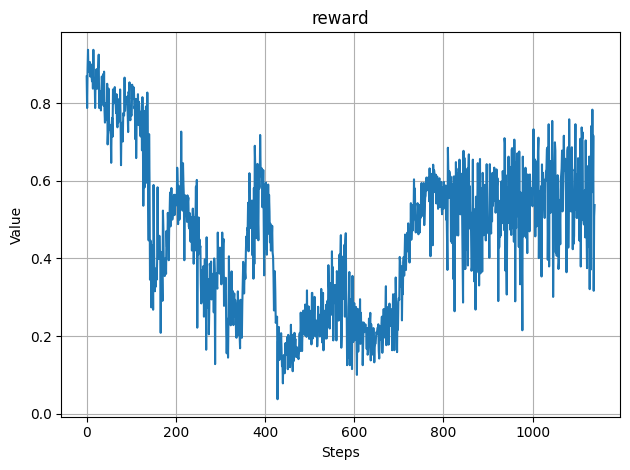

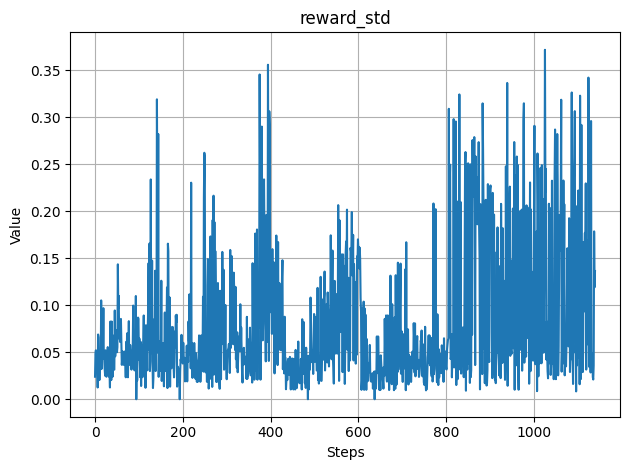

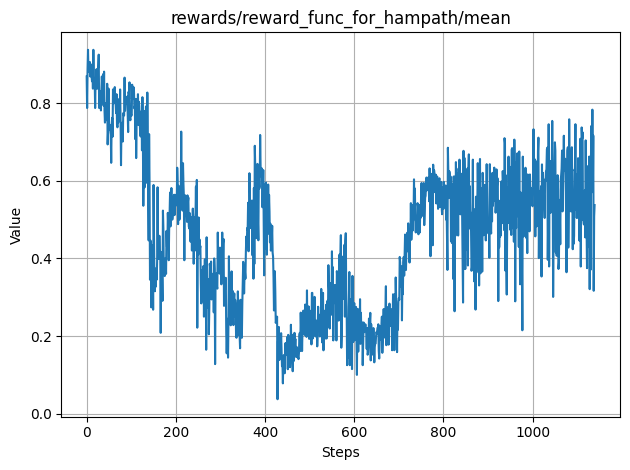

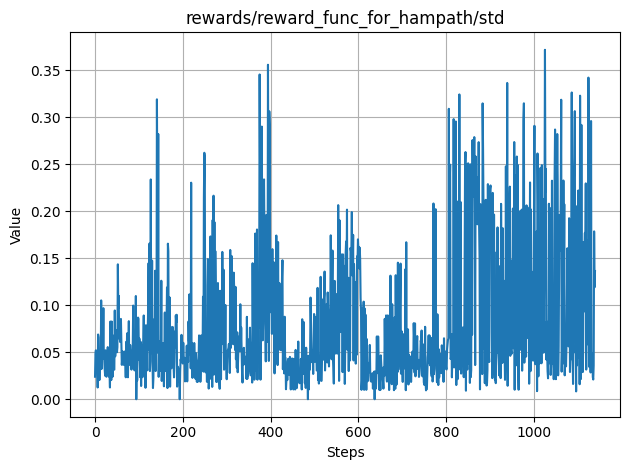

In [ ]:
plot_trl_training_history(trainer.state.log_history)

## Evaluate

In [ ]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = os.path.join(path, 'models/sft-grpo-3-llama-instruct'),
    max_seq_length = max_seq_length,
    fast_inference = False,
    gpu_memory_utilization=1.0,
)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.8: Fast Llama patching. Transformers: 4.55.2. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.8.8 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
from vllm import SamplingParams
from tqdm import tqdm
import numpy as np

sampling_params = SamplingParams(
    top_p=0.9,
    max_tokens=max_completion_length,
)

def run_many_problems(model, tokenizer, dataset, batch_size, generated,
                      generator_params, **generation_kwargs):
    results = []
    formatted_inputs = tokenizer.apply_chat_template(
        dataset['prompt'],
        tokenize=False,
        add_generation_prompt=True
    )
    data_idx = 0

    with torch.no_grad():
        for batch_num in tqdm(range(0, len(dataset), batch_size)):
            start_time = time.time()
            FastLanguageModel.for_inference(model)
            batch = formatted_inputs[batch_num:batch_num + batch_size]
            batch_encodings = tokenizer(batch, return_tensors="pt",
            padding=True).to(model.device)

            outputs = model.generate(
                **batch_encodings,
                do_sample=False,
                top_p=sampling_params.top_p,
                max_new_tokens=sampling_params.max_tokens,
            )
            prompt_lengths = batch_encodings["input_ids"].shape[1]
            generated_tokens = outputs[:, prompt_lengths:]
            completions = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            end_time = time.time()

            for response in completions:
                result = {}
                example = dataset[data_idx]
                data_idx += 1

                result['System Message'] = example['conversations'][0]
                result['Human Message'] = example['conversations'][1]

                result['Prompt'] = example['prompt']
                result['LLM Response'] = response

                llm_answer = extract_subset_from_output(response)
                result['Extracted Answer'] = llm_answer

                is_correct, message = verify_hamiltonian_path(llm_answer, *generated[example['idx']][:1])
                result['Is Correct'] = is_correct
                result['Message'] = message
                result['Reward'] = reward_func_for_hampath([[{'content': response}]], [example['idx']])[0]

                execution_time = (end_time - start_time) / len(completions)
                result['LLM Solve Time'] = execution_time
                results.append(result)

        for i, result in enumerate(results):
            result['Generator Parameters'] = generator_params[i]

    return results

In [ ]:
def plot_reward_distribution(X, y, n_bins=7):
    """
    Plot the average reward for each bin of each feature
    """
    for feature in X.columns:
        plt.figure(figsize=(6, 4))

        feature_values = X[feature]
        bins = np.linspace(feature_values.min(), feature_values.max(), n_bins+1)

        rewards = []
        bin_centers = []

        for i in range(len(bins) - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            bin_center = (lower_bound + upper_bound) / 2

            in_bin_mask = (feature_values >= lower_bound) & (feature_values < upper_bound)

            if in_bin_mask.sum() > 0:
                reward_in_bin = y[in_bin_mask].sum()
                total_in_bin = in_bin_mask.sum()
                proportion = reward_in_bin / total_in_bin

                rewards.append(proportion)
                bin_centers.append(bin_center)

        plt.bar(bin_centers, rewards, width=(bins[1]-bins[0])*0.8)
        plt.xlabel(feature)
        plt.ylabel('Average Reward')
        plt.title(f'Average Reward by {feature}')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [ ]:
def report_results(results):
    df = pd.DataFrame([res['Generator Parameters'] for res in results]).copy()
    df['Is Correct'] = [res['Is Correct'] for res in results]
    df['Length of prompt'] = [
        len(res['Human Message']['content']) for res in results]
    df['Reward'] = [res['Reward'] for res in results]

    features = list(key for key in results[0]['Generator Parameters'].keys()
        if type(results[0]['Generator Parameters'][key])!=bool)
    features.append('Length of prompt')

    X = df[features]
    y = df['Is Correct']

    scatter_plot_correctness(X, y)
    plot_correctness_distribution(X, y)
    plot_reward_distribution(X, df['Reward'])
    plot_feature_importance(X.drop(columns=['Length of prompt']), y)

    print("LLM Solve Time (Average):", np.mean([res['LLM Solve Time'] for res in results]))
    if 'Z3 Solve Time' in results[0].keys():
        print("Z3 Solve Time (Average):", np.mean([res.get('Z3 Solve Time',0) for res in results]))

In [ ]:
test_dataset, generated, generator_params = load_dataset(dataset_path, 0)
grpo_formatter = lambda examples: {"prompt": [example[:-1] for example in examples["conversations"]]}

test_dataset = test_dataset.map(
    grpo_formatter,
    batched=True,
)

In [ ]:
results = run_many_problems(model, tokenizer, test_dataset, 1, generated, generator_params)

100%|██████████| 100/100 [11:41<00:00,  7.01s/it]


# SFT 3 Llama Instruct

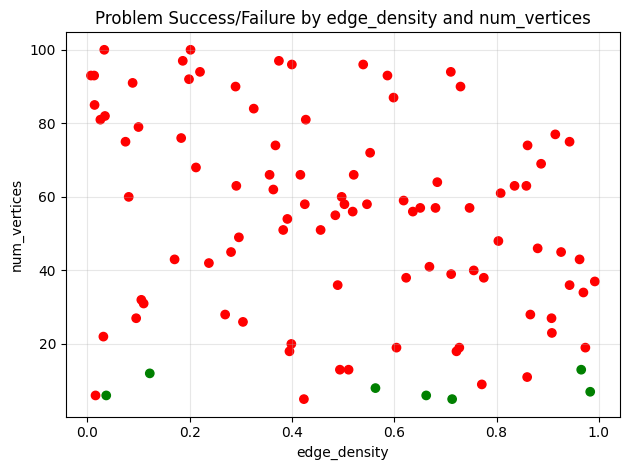

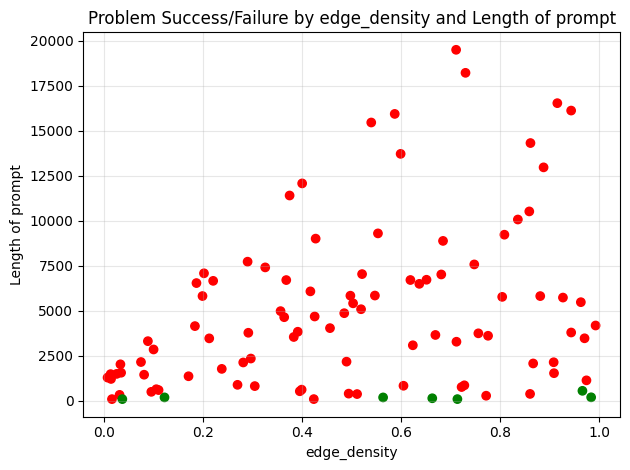

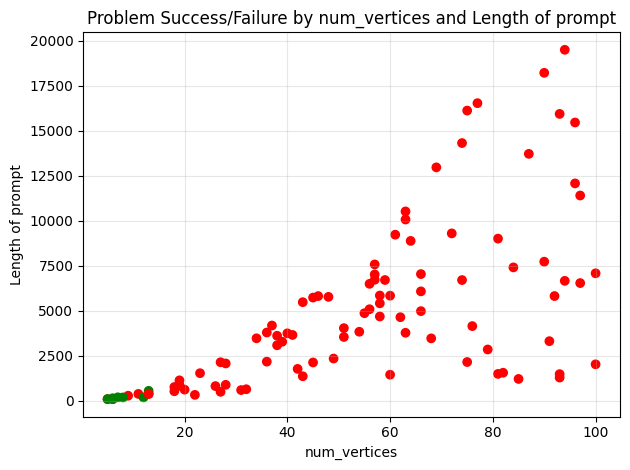

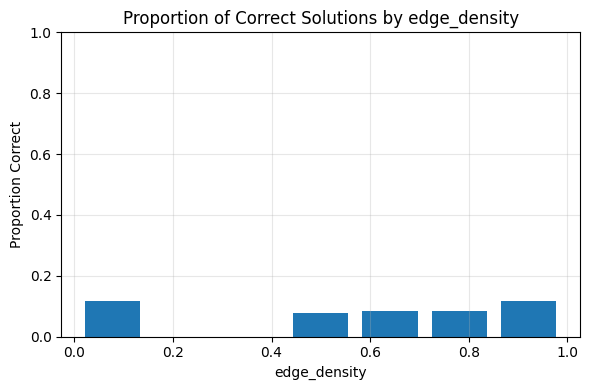

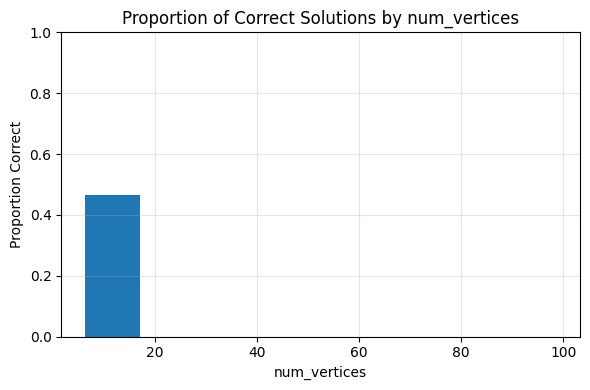

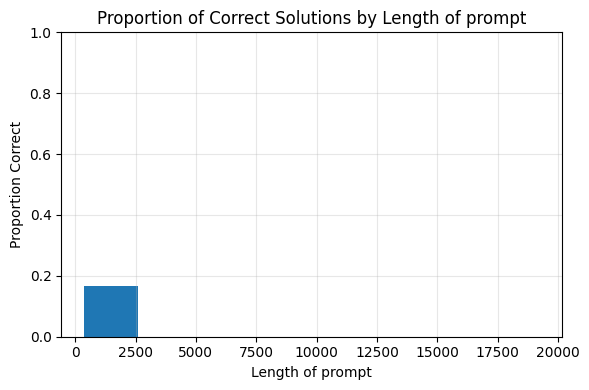

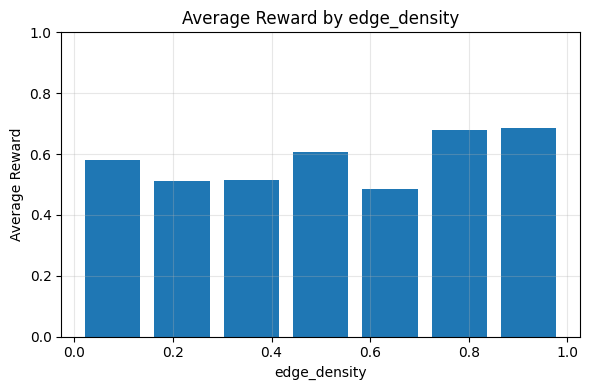

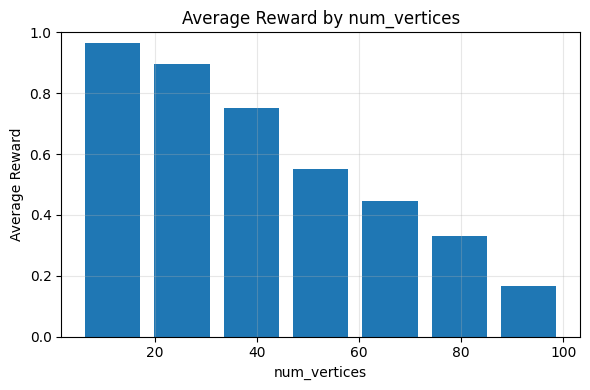

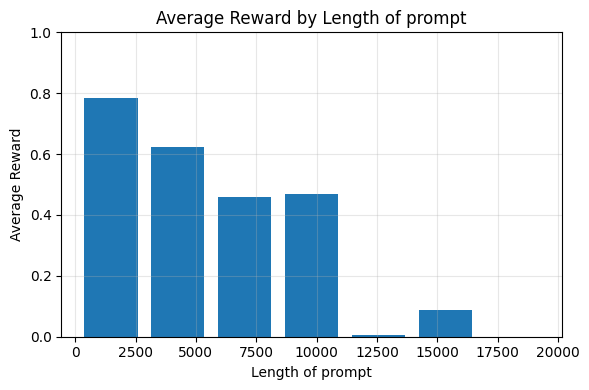

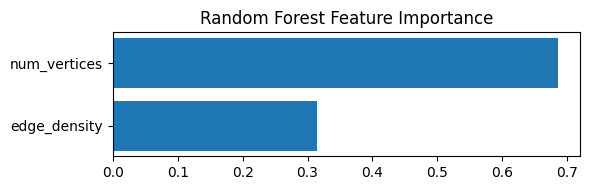

Accuracy: 0.95
F1 Score: 0.6666666666666666
LLM Solve Time (Average): 11.841731672286988


In [ ]:
report_results(results)

# SFT GRPO 3 Llama Instruct

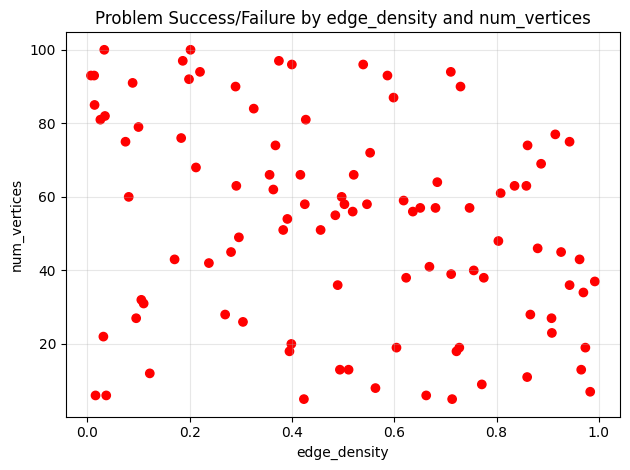

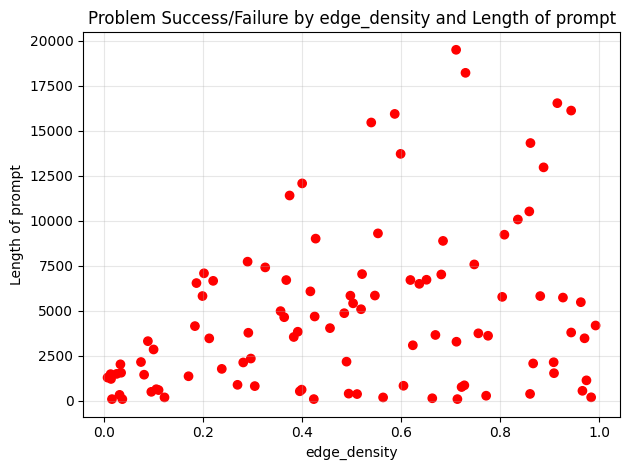

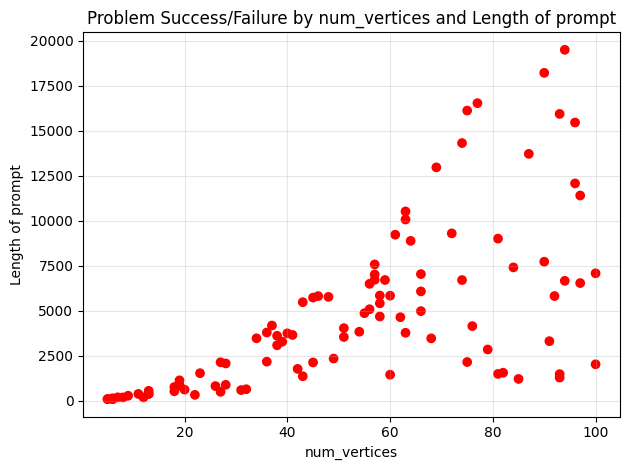

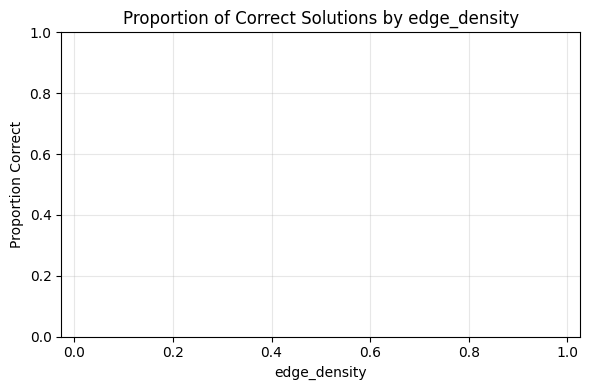

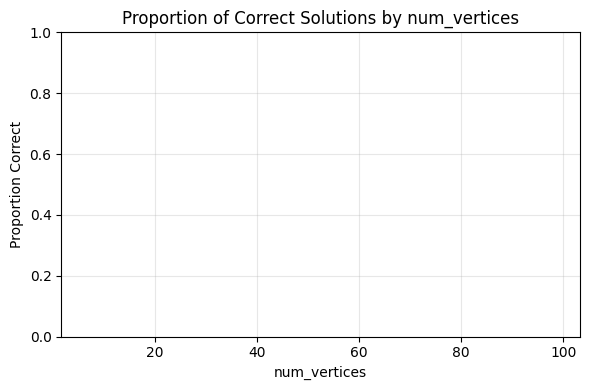

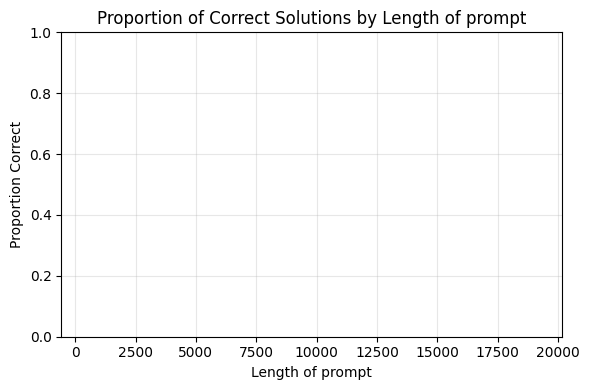

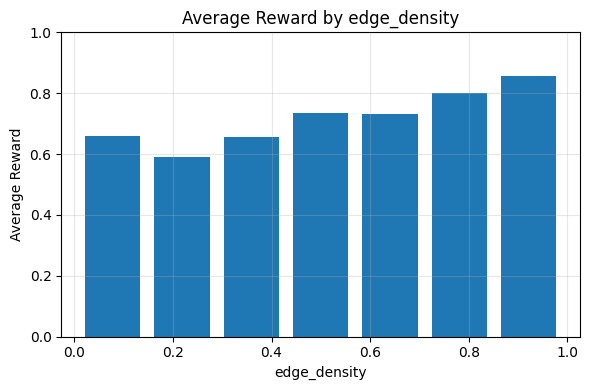

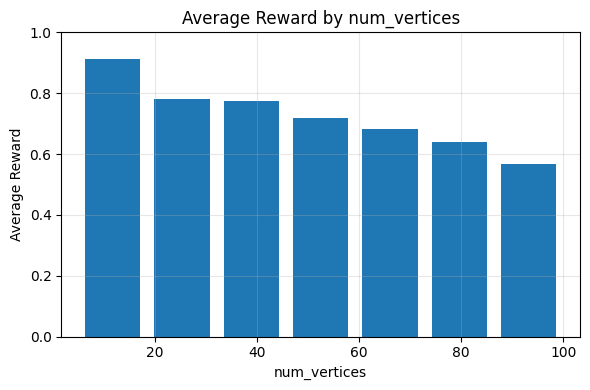

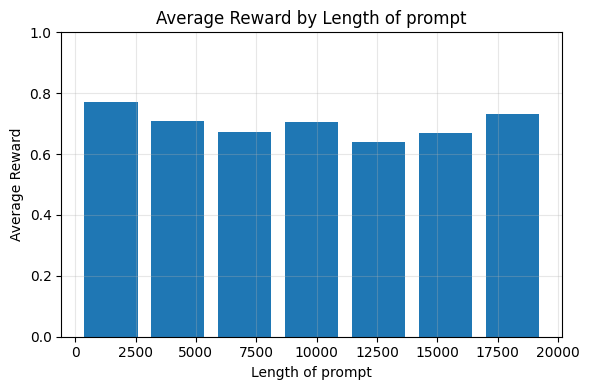

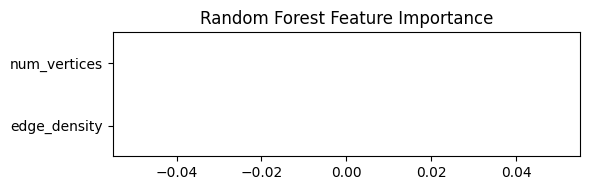

Accuracy: 1.0
F1 Score: 0.0
LLM Solve Time (Average): 6.191072738170623


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report_results(results)

# SFT 4 Llama Instruct

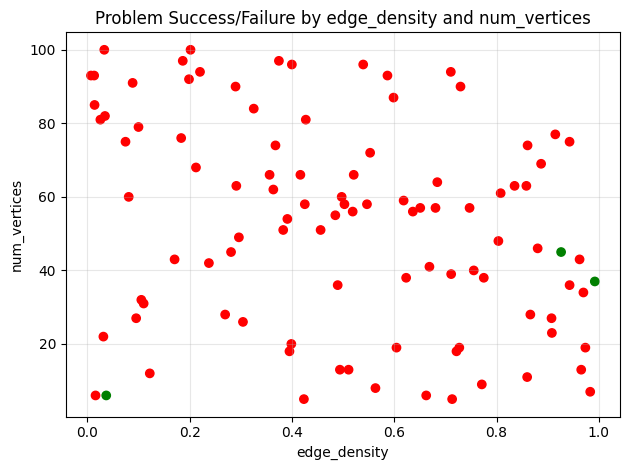

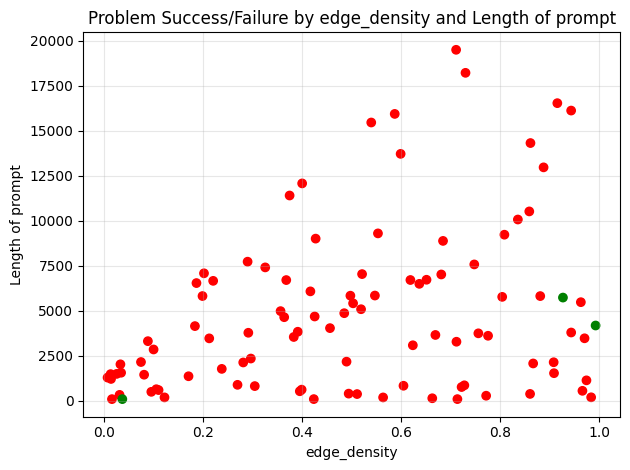

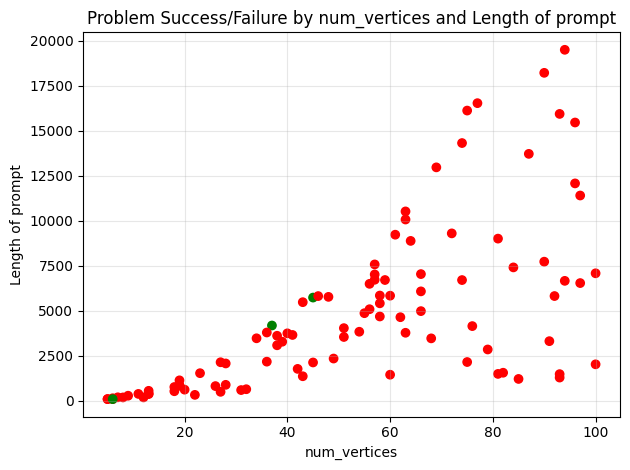

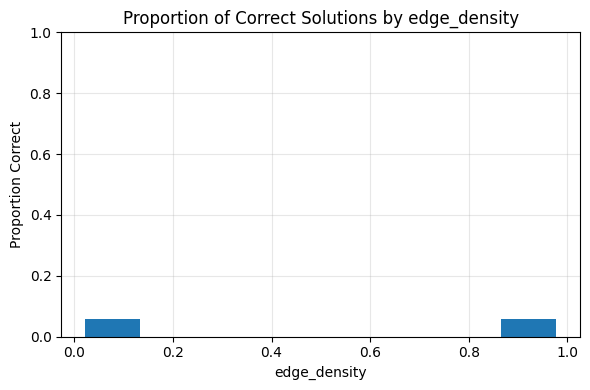

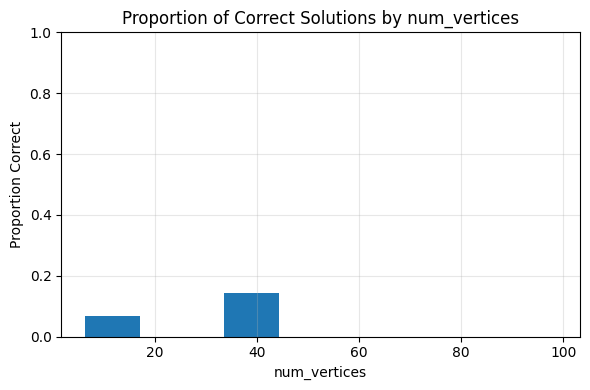

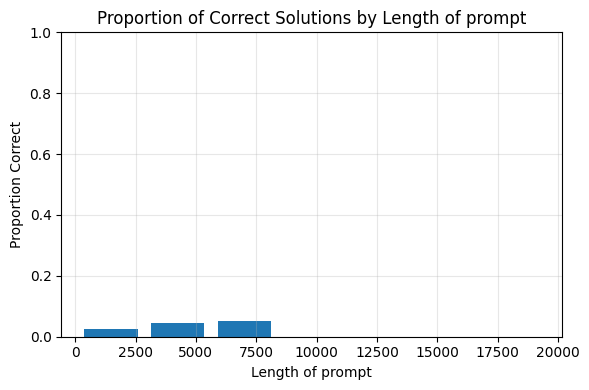

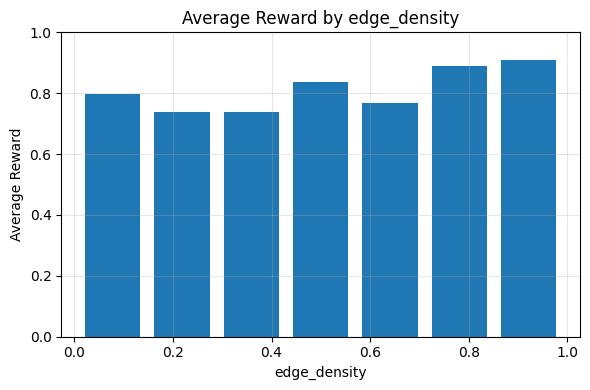

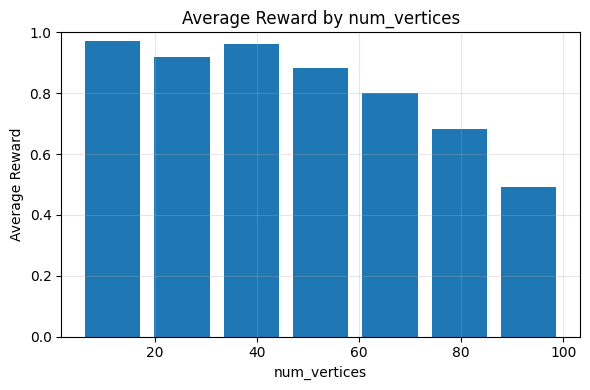

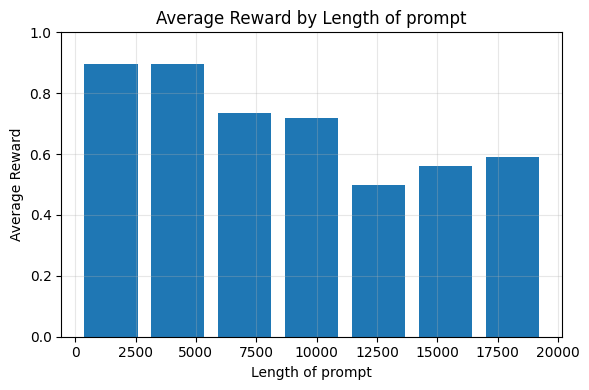

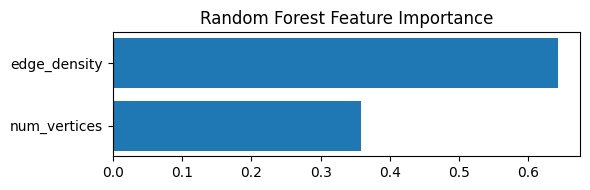

Accuracy: 0.95
F1 Score: 0.0
LLM Solve Time (Average): 4.69341902256012


In [ ]:
report_results(results)

# SFT GRPO 4 Llama Instruct

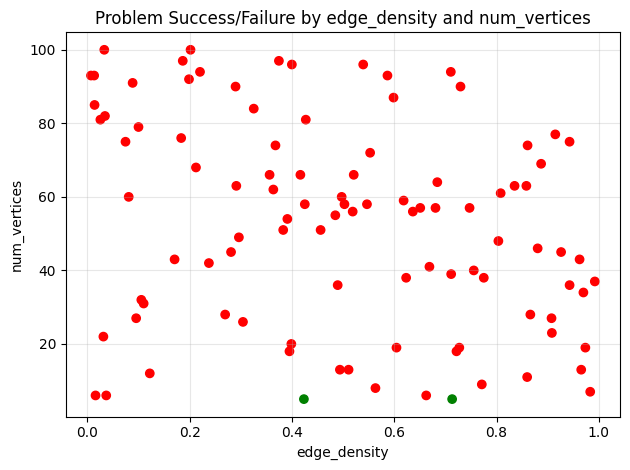

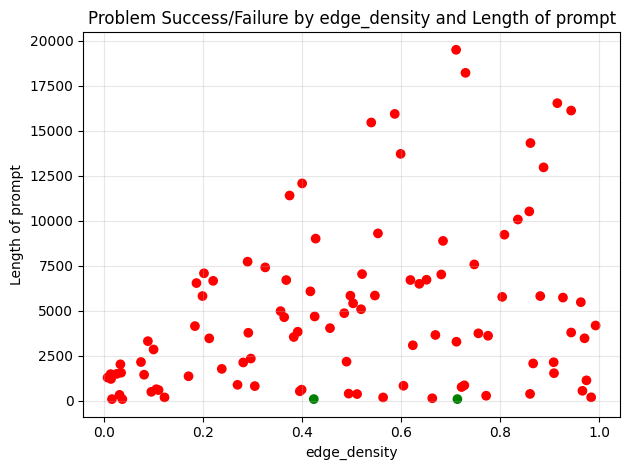

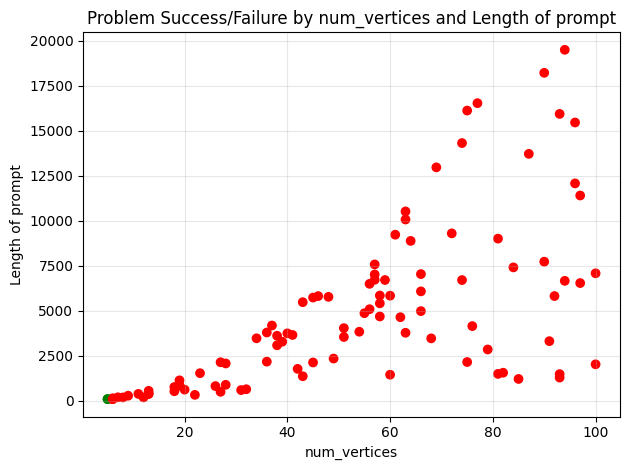

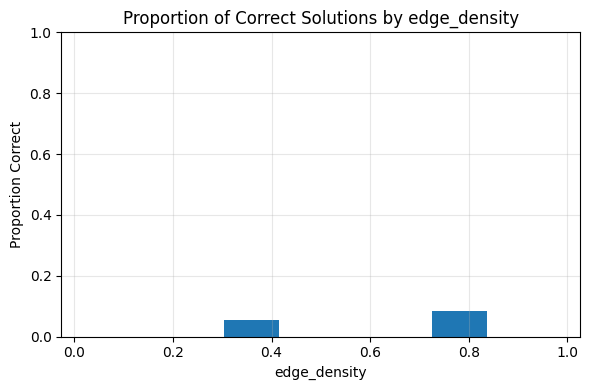

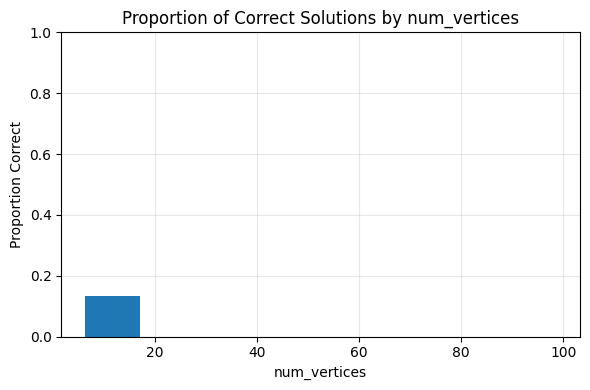

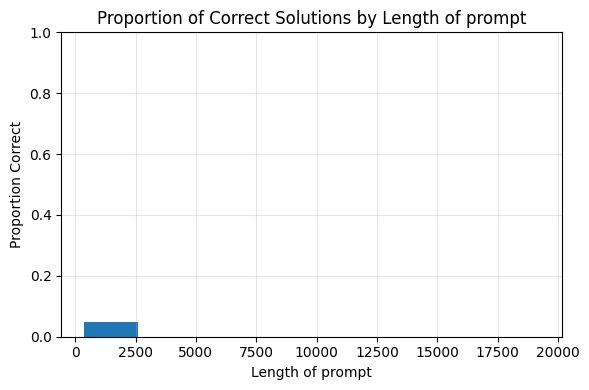

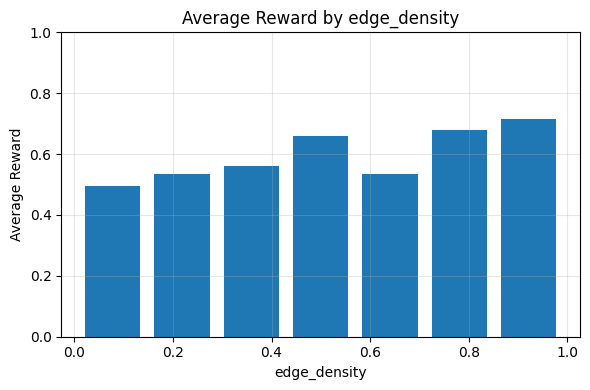

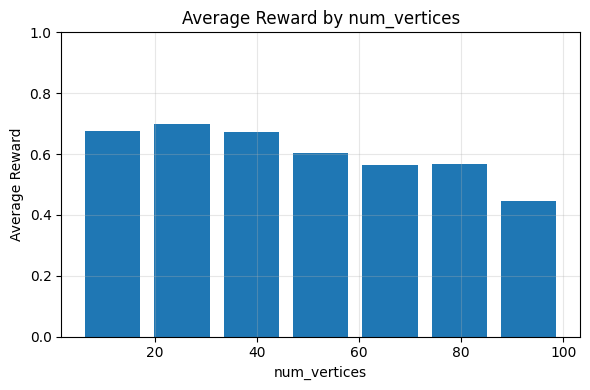

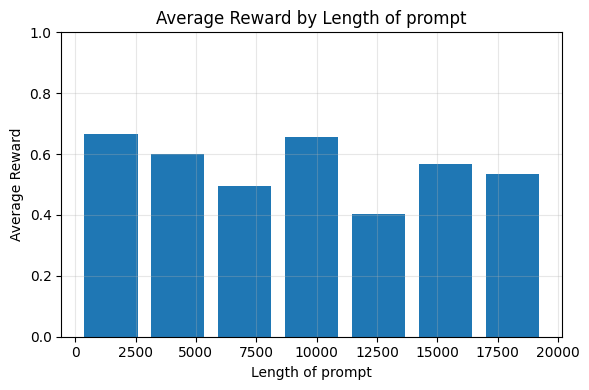

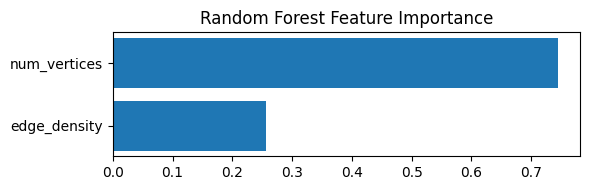

Accuracy: 1.0
F1 Score: 0.0
LLM Solve Time (Average): 6.352057900428772


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report_results(results)

# SFT GRPO 5 Llama Instruct

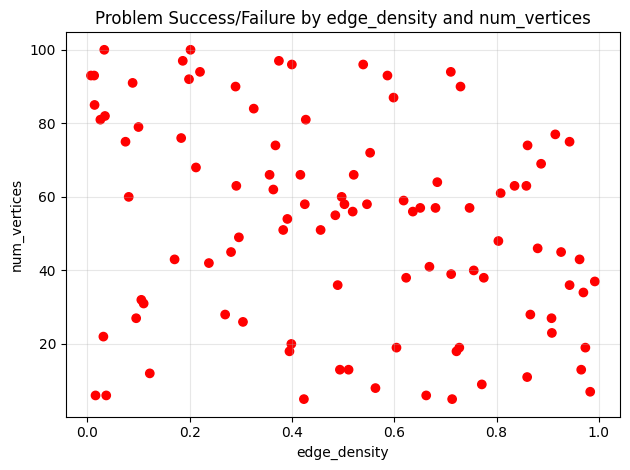

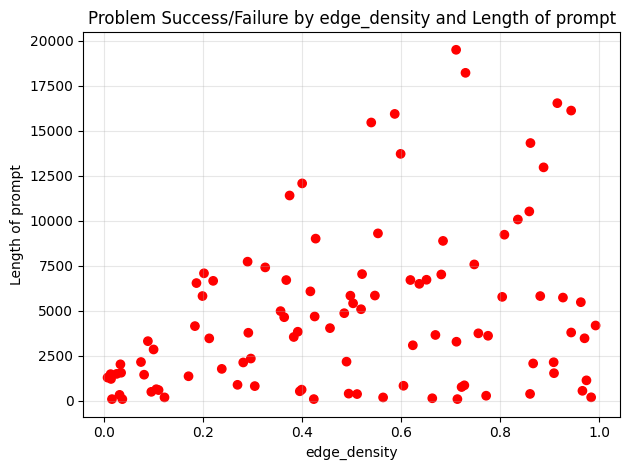

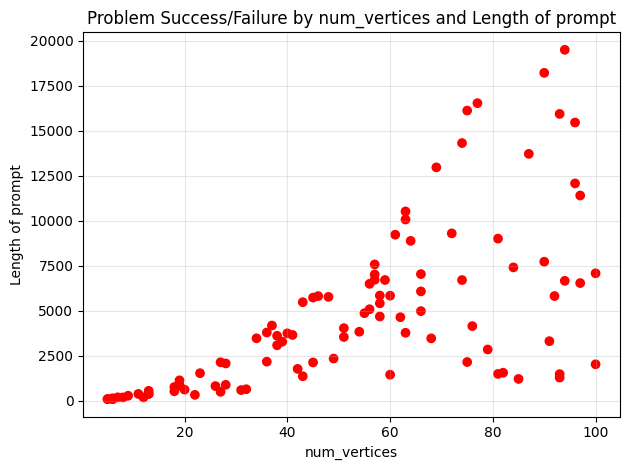

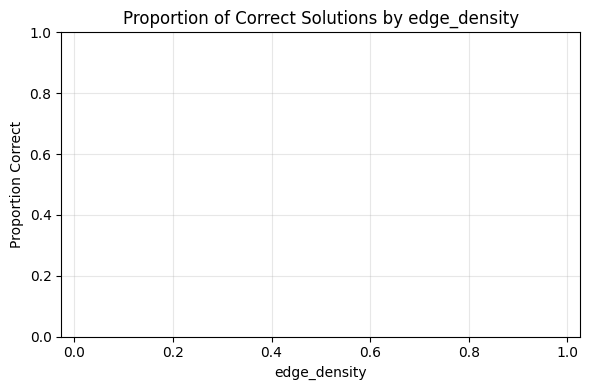

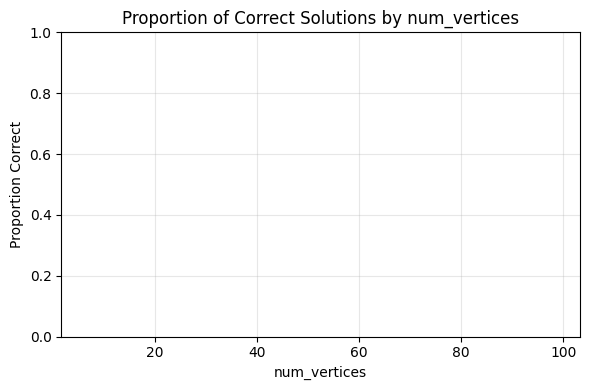

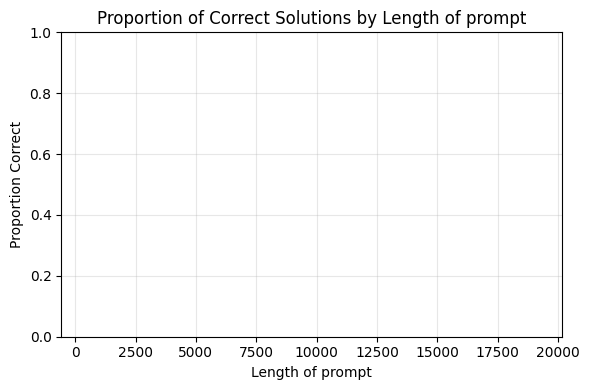

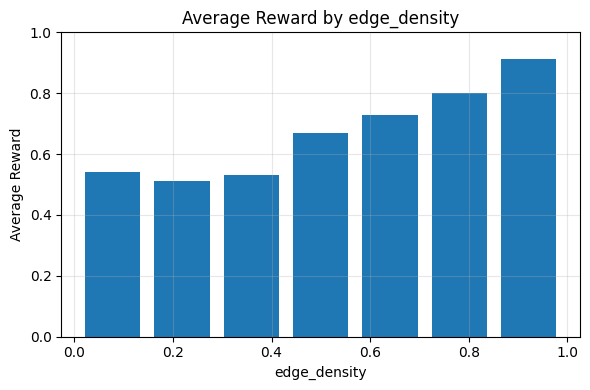

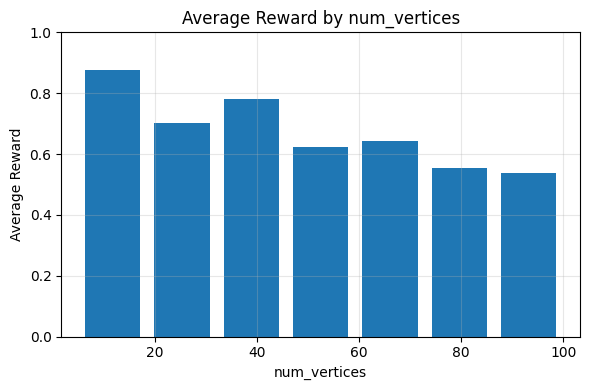

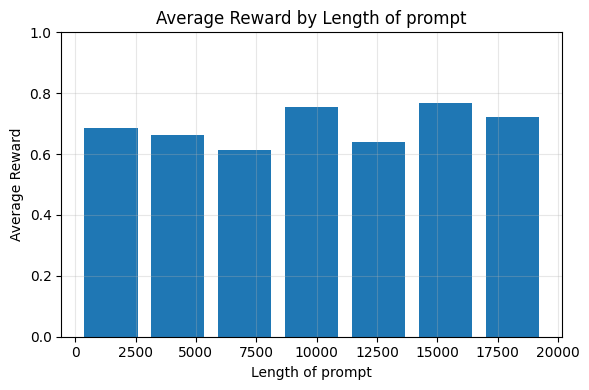

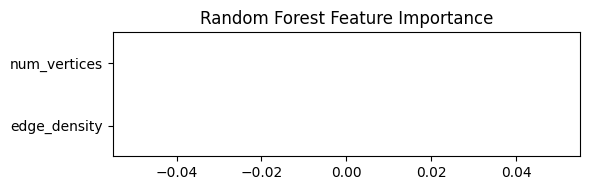

Accuracy: 1.0
F1 Score: 0.0
LLM Solve Time (Average): 7.009543833732605


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report_results(results)